In [1]:
"""
🔹 CELLULE 1 – Simulation d’un modèle linéaire avec bruit gaussien
"""
import numpy as np
from numpy.random import default_rng

rng = default_rng(seed=42)

def generate_linear_data(n, d, theta_true, sigma=1.0):
    X = rng.normal(0, 1, size=(n, d))
    noise = rng.normal(0, sigma, size=n)
    Y = X @ theta_true + noise
    return X, Y


In [2]:
"""
🔹 CELLULE 2 – Estimateur OLS analytique (pseudo-inverse)
"""
from numpy.linalg import pinv

def ols_estimator(X, Y):
    return pinv(X) @ Y


In [3]:
"""
🔹 CELLULE 3 – Risque empirique et vrai risque (MSE), accélérés avec Numba
"""
from numba import jit, prange

@jit(nopython=True, parallel=True)
def mse(y_true, y_pred):
    err = 0.0
    for i in prange(y_true.shape[0]):
        err += (y_true[i] - y_pred[i]) ** 2
    return err / y_true.shape[0]


In [4]:
"""
🔹 CELLULE 4 – Expérience répétée : calcul moyen des risques sur T essais
"""
def run_experiment(n, d, theta_true, sigma=1.0, T=50):
    risk_empirical = []
    risk_true = []
    
    for _ in range(T):
        X, Y = generate_linear_data(n, d, theta_true, sigma)
        theta_hat = ols_estimator(X, Y)
        
        y_hat = X @ theta_hat
        y_clean = X @ theta_true
        
        re = mse(Y, y_hat)              # Risque empirique sur données bruitées
        rt = mse(y_clean, y_hat)       # Vrai risque sur données sans bruit
        
        risk_empirical.append(re)
        risk_true.append(rt)
        
    return np.mean(risk_empirical), np.mean(risk_true)


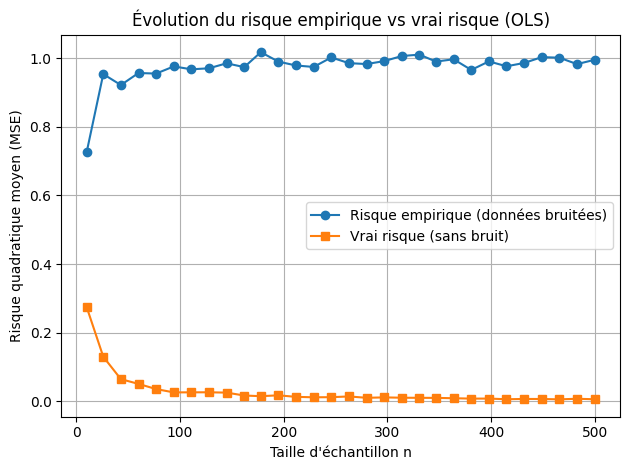

In [6]:
"""
🔹 CELLULE 5 – Étude du risque en fonction de la taille d’échantillon n
"""
import matplotlib.pyplot as plt

theta_true = np.array([1.0, -2.0, 0.5])   # Paramètre vrai
d = len(theta_true)
sigma = 1.0
n_values = np.linspace(10, 500, 30, dtype=int)

empirical_risks = []
true_risks = []

for n in n_values:
    re, rt = run_experiment(n, d, theta_true, sigma=sigma)
    empirical_risks.append(re)
    true_risks.append(rt)

plt.plot(n_values, empirical_risks, label="Risque empirique (données bruitées)", marker='o')
plt.plot(n_values, true_risks, label="Vrai risque (sans bruit)", marker='s')
plt.xlabel("Taille d'échantillon n")
plt.ylabel("Risque quadratique moyen (MSE)")
plt.title("Évolution du risque empirique vs vrai risque (OLS)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("exo3_risques.png")
plt.show()


In [7]:
"""
🔹 CELLULE 6 – Interprétation finale (résumé affiché)
"""
for i, n in enumerate(n_values):
    print(f"n = {n:3d} | Risque empirique = {empirical_risks[i]:.4f} | Vrai risque = {true_risks[i]:.4f}")


n =  10 | Risque empirique = 0.7258 | Vrai risque = 0.2745
n =  26 | Risque empirique = 0.9531 | Vrai risque = 0.1300
n =  43 | Risque empirique = 0.9213 | Vrai risque = 0.0647
n =  60 | Risque empirique = 0.9563 | Vrai risque = 0.0508
n =  77 | Risque empirique = 0.9546 | Vrai risque = 0.0358
n =  94 | Risque empirique = 0.9755 | Vrai risque = 0.0261
n = 111 | Risque empirique = 0.9671 | Vrai risque = 0.0263
n = 128 | Risque empirique = 0.9700 | Vrai risque = 0.0264
n = 145 | Risque empirique = 0.9846 | Vrai risque = 0.0254
n = 162 | Risque empirique = 0.9734 | Vrai risque = 0.0170
n = 178 | Risque empirique = 1.0169 | Vrai risque = 0.0150
n = 195 | Risque empirique = 0.9894 | Vrai risque = 0.0176
n = 212 | Risque empirique = 0.9782 | Vrai risque = 0.0131
n = 229 | Risque empirique = 0.9740 | Vrai risque = 0.0118
n = 246 | Risque empirique = 1.0017 | Vrai risque = 0.0122
n = 263 | Risque empirique = 0.9850 | Vrai risque = 0.0143
n = 280 | Risque empirique = 0.9824 | Vrai risque = 0.01